# Variational Inference with HSSM

Through our [PyMC](https://www.pymc.io/welcome.html) interface, we also gain access to approximate posteriors via Variational Inference. This tutorial illustrates how to perform variational inference via HSSM.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import hssm

hssm.set_floatX("float32")
import arviz as az
import pymc as pm

Setting PyTensor floatX type to float32.
Setting "jax_enable_x64" to False. If this is not intended, please set `jax` to False.


# Load Data and Specify model

In [ ]:
cav_data = hssm.load_data("cavanagh_theta")
cav_model = hssm.HSSM(data=cav_data, model="angle")

Model initialized successfully.


## Inference

We will run MCMC and VI here to contrast results. 


### Run VI

In [ ]:
vi_idata = cav_model.vi(niter=100000, method="fullrank_advi")

Using MCMC starting point defaults.


Output()

Finished [100%]: Average Loss = 6,035.9


### Run MCMC

In [ ]:
mcmc_idata = cav_model.sample()

Using default initvals. 



/Users/afengler/miniconda3/envs/hssm516/lib/python3.11/site-packages/pymc/sampling/jax.py:451: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
/Users/afengler/miniconda3/envs/hssm516/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
/Users/afengler/miniconda3/envs/hssm516/lib/python3.11/site-packages

## Inspect Outputs

From our variational inference runs, we extract two objects. 

1. An `az.InferenceData` object stored under `cav_model.vi_idata`. This stores a slightly cleaned up posterior sample, constructed by sampling from the variational posterior.
2. An `pm.Approximator` object stored under `cav_model.vi_approx` that holds the variational posterior object itself. This is a rich structure and it is beyond the purpose of this tutorial to illustrate all it's details. Amongst other things you will be able to inspect the loss history and take samples such as those stored under `cam_model.vi_data`.

### `.vi_idata`

The approximate variational posterior `InferenceData`.

In [ ]:
cav_model.vi_idata

Inference data with groups:
	> posterior
	> observed_data

### `.vi_approx`

The approximate variational posterior `pm.Approximator` object.

We can take draws from the posterior with the `.sample()` method.

In [ ]:
cav_model.vi_approx.sample(draws=1000)

Inference data with groups:
	> posterior
	> observed_data

The `.hist` attribute stores the loss history. We can plot this to see how the loss function converged.

Text(0, 0.5, 'Loss')

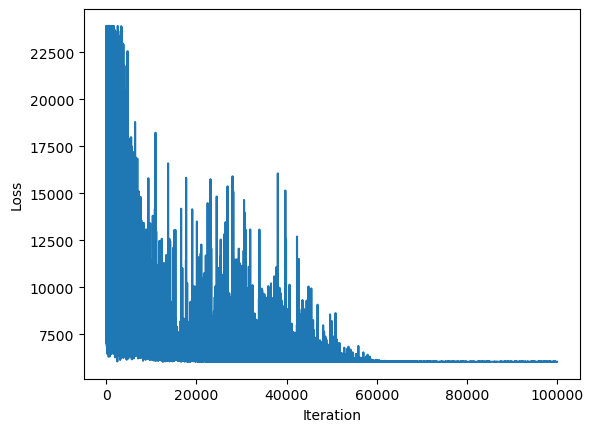

In [ ]:
plt.plot(cav_model.vi_approx.hist)
plt.xlabel("Iteration")
plt.ylabel("Loss")

## Contrast outputs between MCMC and VI

array([[<Axes: ylabel='v'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='theta'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='a'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='t', ylabel='z'>, <Axes: xlabel='v'>,
        <Axes: xlabel='theta'>, <Axes: xlabel='a'>]], dtype=object)

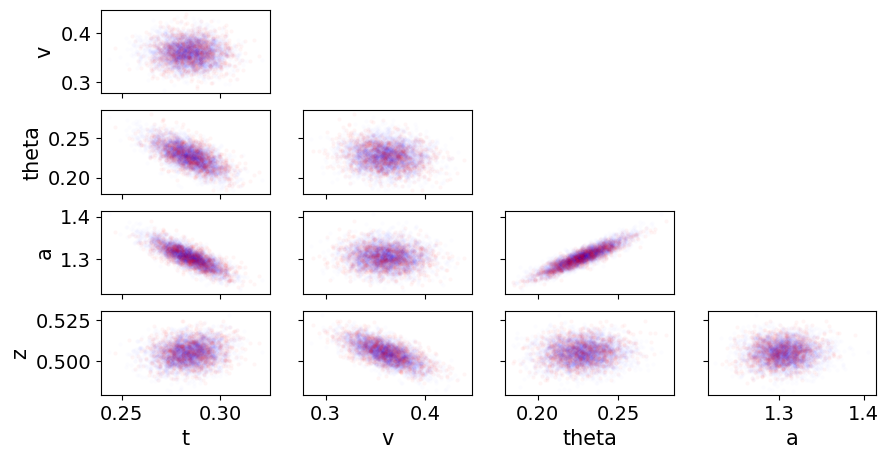

In [ ]:
__, axes = plt.subplots(4, 4, figsize=(10, 5))
az.plot_pair(cav_model.traces, ax=axes, scatter_kwargs=dict(alpha=0.01, color="blue"))
az.plot_pair(cav_model.vi_idata, ax=axes, scatter_kwargs=dict(alpha=0.04, color="red"))

In [ ]:
cav_model.traces

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

### Further Reading

We suggest to check out the [documentation on the VI api in Pymc](https://www.pymc.io/projects/docs/en/stable/api/generated/pymc.FullRankADVI.html) for the full glory details of the capabilities we have access to.

### Working directly through PyMC

Here we illustrate how to use our attached `pymc_model` to make use of the object oriented API for variational inference. This allows us a few extra affordances.

Let's define a few helper functions first.

In [ ]:
import warnings

import xarray as xr
from matplotlib import gridspec
from pymc.blocking import DictToArrayBijection, RaveledVars


def tracker_to_idata(tracker, model):
    """Turn a tracker object into an InferenceData object."""
    tracker_groups = list(tracker.whatchdict.keys())
    # n_steps = len(tracker[tracker_groups[0]])
    stacked_results = {
        tracker_group: {
            key: np.stack([d[key] for d in tracker[tracker_group]])
            for key in tracker[tracker_group][0]
        }
        for tracker_group in tracker_groups
    }

    # coords = {"vi_step": np.arange(n_steps)} | {
    #     k: np.array(v) for k, v in model.coords.items()
    # }
    var_to_dims = {
        var.name: ("vi_step", *(model.named_vars_to_dims.get(var.name, ())))
        for var in model.continuous_value_vars
    }
    datasets = {
        key: xr.Dataset(
            {
                var: (var_to_dims[var], stacked_results[key][var])
                for var in stacked_results[key].keys()
            }
        )
        for key in tracker_groups
    }

    with warnings.catch_warnings(action="ignore"):
        return az.InferenceData(**datasets)


def untransform_params(idata, model):
    """Bring transformed parmater back to their original scale."""
    suffixes = ["_interval__", "_log__"]

    def remove_suffixes(word, suffixes):
        for suffix in suffixes:
            if word.endswith(suffix):
                return word[: -len(suffix)]
        return word

    free_rv_names = [rv_.name for rv_ in model.free_RVs]
    transformed_vars = list(idata.mean.data_vars.keys())
    collect_untransformed_vars = []
    collect_untransformed_xarray_datasets = []

    for var_ in transformed_vars:
        var_untrans = remove_suffixes(var_, suffixes=suffixes)
        if var_untrans in free_rv_names:
            rv = model.free_RVs[free_rv_names.index(var_untrans)]
            if model.rvs_to_transforms[rv] is not None:
                untransformed_var = (
                    model.rvs_to_transforms[rv]
                    .backward(idata.mean[var_].values, *rv.owner.inputs)
                    .eval()
                )
                collect_untransformed_vars.append(var_)
                collect_untransformed_xarray_datasets.append(
                    xr.Dataset(
                        data_vars={var_untrans: (("vi_step"), untransformed_var)}
                    )
                )

    return xr.merge([idata.mean] + collect_untransformed_xarray_datasets).drop_vars(
        collect_untransformed_vars
    )


def plot_vi_traces(idata):
    """Plot parameter history of the optimization alogrithm."""
    if not isinstance(idata, az.InferenceData):
        raise ValueError("idata must be an InferenceData object")
    if "loss" not in idata.groups():
        raise ValueError("InferenceData object must contain a 'loss' group")
    if "mean_untransformed" not in idata.groups():
        print(
            "Using transformed variables because 'mean_untransformed' group not found"
        )
        data_vars = list(idata["mean"].data_vars.keys())
    else:
        data_vars = list(idata["mean_untransformed"].data_vars.keys())

    fig = plt.figure(figsize=(8, 1.5 * len(data_vars)))
    gs = gridspec.GridSpec(
        len(data_vars) // 2 + 2
        if (len(data_vars) % 2) == 0
        else (len(data_vars) // 2) + 3,
        2,
    )

    for i, var_ in enumerate(data_vars):
        ax_tmp = fig.add_subplot(gs[i // 2, i % 2])
        idata["mean_untransformed"][var_].plot(ax=ax_tmp)
        ax_tmp.set_title(var_)

    last_ax = fig.add_subplot(gs[-2:, :])
    idata["loss"].loss.plot(ax=last_ax)
    gs.tight_layout(fig)
    return fig

In [ ]:
# Define the ADVI runner
with cav_model.pymc_model:
    advi = pm.ADVI()

In [ ]:
# Set up starting point
start = cav_model.pymc_model.initial_point()
vars_dict = {var.name: var for var in cav_model.pymc_model.continuous_value_vars}
x0 = DictToArrayBijection.map(
    {var_name: value for var_name, value in start.items() if var_name in vars_dict}
)

# Define quantities to track
tracker = pm.callbacks.Tracker(
    mean=lambda: DictToArrayBijection.rmap(
        RaveledVars(advi.approx.mean.eval(), x0.point_map_info), start
    ),  # callable that returns mean
    std=lambda: DictToArrayBijection.rmap(
        RaveledVars(advi.approx.std.eval(), x0.point_map_info), start
    ),  # callable that returns std
)

In [ ]:
# Run VI fit
approx = advi.fit(n=30000, callbacks=[tracker])
vi_posterior_samples = approx.sample(1000)
vi_posterior_samples.posterior = vi_posterior_samples.posterior.drop_vars("v_mean")

Output()

Finished [100%]: Average Loss = 6,037.3


In [ ]:
from copy import deepcopy

# Convert tracked quantities to idata
result = tracker_to_idata(tracker, cav_model.pymc_model)

# Add untransformed parameters
result.add_groups(
    {"mean_untransformed": untransform_params(deepcopy(result), cav_model.pymc_model)}
)
# Add loss group
result.add_groups(
    {"loss": xr.Dataset(data_vars={"loss": ("vi_step", np.array(approx.hist))})}
)

/Users/afengler/miniconda3/envs/hssm516/lib/python3.11/site-packages/arviz/data/inference_data.py:1538: UserWarning: The group mean_untransformed is not defined in the InferenceData scheme
  warnings.warn(
/Users/afengler/miniconda3/envs/hssm516/lib/python3.11/site-packages/arviz/data/inference_data.py:1538: UserWarning: The group loss is not defined in the InferenceData scheme
  warnings.warn(


A quick look at our `result` `InferenceData` object, to understand what happened here.

We now have two additional groups:
1. `mean_untransformed` which holds parameter values in the orignal space (instead of the parameters over which the optimization operates, which will always live in an unconstrained space)
2. `loss` which holds our training history

In [ ]:
result

Inference data with groups:
	> mean
	> std
	> mean_untransformed
	> loss

### Plot Results

We can plot the parameter trajectories (histories) over optimization steps, with our little helper function `plot_vi_traces()`. 

**NOTE**:

This is a random run, and we did not thoroughly check if the number of steps we allowed the optimizer were indeed enough to converge.

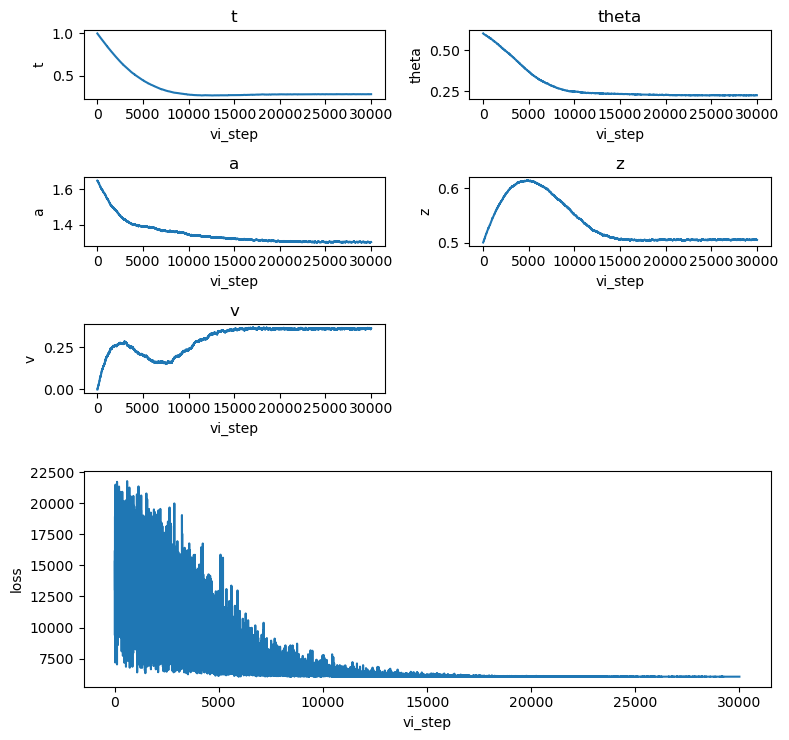

In [ ]:
fig = plot_vi_traces(result)

array([[<Axes: ylabel='v'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='theta'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='a'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='t', ylabel='z'>, <Axes: xlabel='v'>,
        <Axes: xlabel='theta'>, <Axes: xlabel='a'>]], dtype=object)

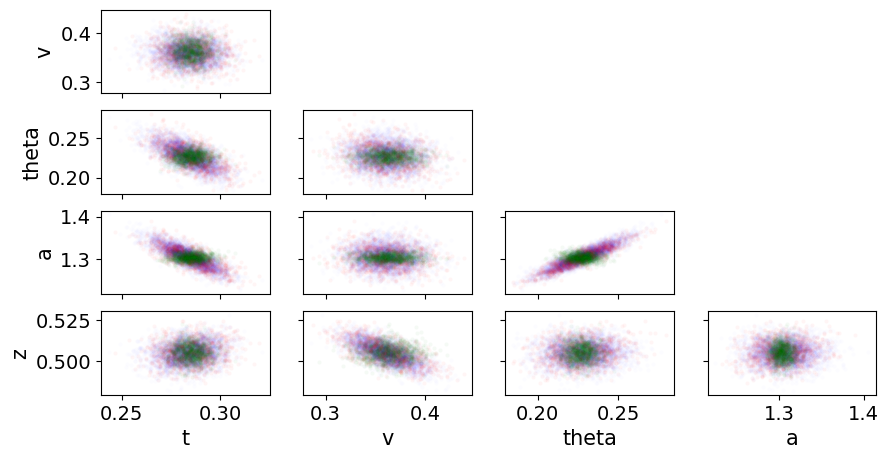

In [ ]:
__, axes = plt.subplots(4, 4, figsize=(10, 5))

# Plot MCMC [nuts]
az.plot_pair(cav_model.traces, ax=axes, scatter_kwargs=dict(alpha=0.01, color="blue"))
# Plot VI via .vi() [fullrank_advi]
az.plot_pair(cav_model.vi_idata, ax=axes, scatter_kwargs=dict(alpha=0.04, color="red"))
# Plot VI via pymc interface [advi]
# (We need to make sure the variables are in correct order)
az.plot_pair(
    vi_posterior_samples.posterior[list(cav_model.traces.posterior.data_vars)],
    ax=axes,
    scatter_kwargs=dict(alpha=0.04, color="green"),
)

**NOTE**:

It is expected that the posterior of our last run looks a little worse. We chose to run the `advi` algorithm, which implies only an *isotropic Gaussian* approximation to the posterior, so we expect to miss the posterior covariances which we pick up via `fullrank_advi` as well as MCMC.

### Caveats

Variational Inference is powerful, however it comes with it's own set of sharp edges. 

1. You will not always be in a position to compare VI with MCMC runs (after all if you can run full MCMC, there isn't much benefit to using VI at all) and it can be hard to a priori estimate how many steps you may need to run the algorithm for.
2. The posteriors will be approximate, if the true posterior includes complex parameter trade-offs, VI might result in inaccurate posterior estimates.
3. We recommend VI for `loglik_kind="approx_differentiable"`, since the gradients of the `analytical` log-likelihoods still prove somewhat brittle at this point in time.

### Read

To learn a bit more about the VI-API in [PyMC](https://www.pymc.io/welcome.html), we recommend you to read the excellent [short tutorial](https://www.pymc.io/projects/examples/en/latest/variational_inference/variational_api_quickstart.html) in the main documentation.